# BTC Price Prediction

In [1]:
# from utils import *

import time
import numpy as np
import pandas as pd

from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

import math
import requests
import json
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
context = mx.cpu()
model_ctx = mx.cpu()
mx.random.seed(1719)

# GET Bitcoin DATA

In [4]:
#data convert 
def parser(t):
     return datetime.datetime.strptime(t, "%Y-%m-%d")

In [5]:
btc_df= pd.read_csv('../data/BTC-USD.csv', header=0, parse_dates=[0], date_parser=parser)
# btc_df=btc_df.set_index('Date')
btc_df = btc_df[(btc_df['Date'] > '2014-09-17') & (btc_df['Date'] <= '2021-05-05')]
btc_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0
5,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,24127600.0


In [6]:
btc_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2418,2021-05-01,57714.664063,58448.339844,57052.273438,57828.050781,57828.050781,4.283643e+10
2419,2021-05-02,57825.863281,57902.593750,56141.906250,56631.078125,56631.078125,3.817741e+10
2420,2021-05-03,56620.273438,58973.308594,56590.871094,57200.292969,57200.292969,5.171314e+10
2421,2021-05-04,57214.179688,57214.179688,53191.425781,53333.539063,53333.539063,6.856471e+10
2422,2021-05-05,53252.164063,57911.363281,52969.054688,57424.007813,57424.007813,6.924132e+10


In [7]:
# number of data
print("number of day in file : ",len(btc_df))

number of day in file :  2422


In [8]:
btc_df

,Date,Open,High,Low,Close,Adj Close,Volume
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,3.448320e+07
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,3.791970e+07
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,3.686360e+07
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,2.658010e+07
5,2014-09-22,399.100006,406.915985,397.130005,402.152008,402.152008,2.412760e+07
...,...,...,...,...,...,...,...
2418,2021-05-01,57714.664063,58448.339844,57052.273438,57828.050781,57828.050781,4.283643e+10
2419,2021-05-02,57825.863281,57902.593750,56141.906250,56631.078125,56631.078125,3.817741e+10
2420,2021-05-03,56620.273438,58973.308594,56590.871094,57200.292969,57200.292969,5.171314e+10
2421,2021-05-04,57214.179688,57214.179688,53191.425781,53333.539063,53333.539063,6.856471e+10


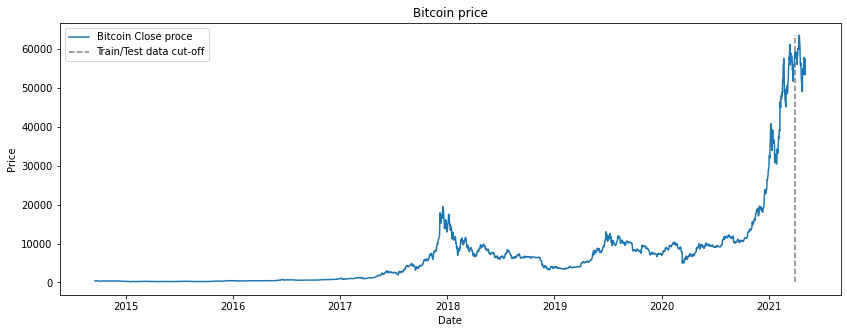

In [9]:
y_height = max(btc_df['Close'])
plt.figure(figsize=(14,5))
plt.plot(btc_df['Date'], btc_df['Close'], label='Bitcoin Close proce')
plt.vlines(datetime.date(2021,4, 1), 0, y_height, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin price')
plt.legend()
plt.show()

In [10]:
num_training_days = int(btc_df.shape[0]*.975)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, \
                                                                    btc_df.shape[0]-num_training_days))

Number of training days: 2361. Number of test days: 61.


# Correlated assets

In [11]:
# list all files 
for file in os.listdir("../data/correlated assets/"):
    print(file)

Bitcoin price volatility.csv
ETH-USD.csv
.DS_Store
market_dominance_data.csv
market_dominance_data.json
Bitcoin network hashrate.csv
Bitcoin trading volume.csv
Blockchain blocks size.csv
Bitcoin mining difficulty.csv
SP500.csv
LTC-USD.csv


### get assets 

In [12]:
# ETH
eth_df= pd.read_csv('../data/correlated assets/ETH-USD.csv', header=0)
# eth_df=eth_df.set_index('Date')
# eth_df = eth_df.loc["2014-09-17":"2021-05-05"]
# btc_df=btc_df.set_index('Date')
eth_df = eth_df[(eth_df['Date'] > '2014-09-17') & (eth_df['Date'] <= '2021-05-05')]
eth_df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-08-07,2.831620,3.53661,2.521120,2.772120,2.772120,164329.0
1,2015-08-08,2.793760,2.79881,0.714725,0.753325,0.753325,674188.0
2,2015-08-09,0.706136,0.87981,0.629191,0.701897,0.701897,532170.0


In [13]:
eth_df.tail(3)

,Date,Open,High,Low,Close,Adj Close,Volume
2096,2021-05-03,2951.175781,3450.037842,2951.175781,3431.086182,3431.086182,4.917429e+10
2097,2021-05-04,3431.131592,3523.585938,3180.742676,3253.629395,3253.629395,6.240205e+10
2098,2021-05-05,3240.554688,3541.462646,3213.101563,3522.783203,3522.783203,4.833420e+10


In [14]:
# LTC
ltc_df= pd.read_csv('../data/correlated assets/LTC-USD.csv', header=0)
# ltc_df=ltc_df.set_index('Date')
# ltc_df = ltc_df.loc["2014-09-17":"2021-05-05"]
ltc_df = ltc_df[(ltc_df['Date'] > '2014-09-17') & (ltc_df['Date'] <= '2021-05-05')]
ltc_df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume
1,2014-09-18,5.06543,5.06543,4.57996,4.68523,4.68523,4569260.0
2,2014-09-19,4.68729,4.75582,4.25435,4.32777,4.32777,3917450.0
3,2014-09-20,4.32920,4.61608,4.20219,4.28644,4.28644,5490660.0


In [15]:
ltc_df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2418,2021-05-01,271.142670,278.219421,266.631409,276.833527,276.833527,3.611806e+09
2419,2021-05-02,276.960419,277.483459,265.335724,269.104370,269.104370,3.118501e+09
2420,2021-05-03,269.008301,299.300537,268.728973,294.704010,294.704010,5.172505e+09
2421,2021-05-04,294.774261,326.888672,275.464966,306.234497,306.234497,1.154125e+10
2422,2021-05-05,305.177399,359.500153,301.451569,356.037079,356.037079,1.318354e+10


In [16]:
# sp500
sp500_df= pd.read_csv('../data/correlated assets/SP500.csv', header=0)
# sp500_df=sp500_df.set_index('Date')
# sp500_df = sp500_df.loc["2014-09-17":"2021-05-05"]
sp500_df = sp500_df[(sp500_df['Date'] > '2014-09-17') & (sp500_df['Date'] <= '2021-05-05')]
sp500_df.head(3)

,Date,Open,High,Low,Close,Volume
36766,2014-09-18,2003.07,2012.34,2003.07,2011.36,1.797411e+09
36767,2014-09-19,2012.74,2019.26,2006.59,2010.40,2.711233e+09
36768,2014-09-22,2009.08,2009.08,1991.01,1994.29,1.860928e+09


In [17]:
sp500_df.tail(3)

,Date,Open,High,Low,Close,Volume
38432,2021-05-03,4191.98,4209.39,4188.03,4192.66,2.182103e+09
38433,2021-05-04,4179.04,4179.04,4128.59,4164.66,2.552420e+09
38434,2021-05-05,4177.06,4187.72,4160.94,4167.59,1.769153e+09


In [18]:
# Bitcoin market capitalization.csv 
def capitalizatio_time(t):
    return t.replace("00:00:00 UTC","")
bmc_df= pd.read_csv('../data/correlated assets/market_dominance_data.csv', header=0)
# bmc_df['Time'] = bmc_df['Time'].apply(lambda x:capitalizatio_time(x))
# bmc_df.columns = ['Date', 'capitalization']
# bmc_df=bmc_df.set_index('Date')
bmc_df = bmc_df[(bmc_df['Date'] > '2014-09-17') & (bmc_df['Date'] <= '2021-05-05')]
bmc_df.tail(3)

,Date,market_dominance
2909,2021-05-03,46.02
2910,2021-05-04,44.57
2911,2021-05-05,43.47


In [19]:
def blocks_time(t):
    return t.replace("00:00:00 UTC","")
    
# Blockchain blocks size
bbs_df= pd.read_csv('../data/correlated assets/Blockchain blocks size.csv', header=0)
bbs_df['Time'] = bbs_df['Time'].apply(lambda x:blocks_time(x))
bbs_df.columns = ['Date', 'size']
# bbs_df=bbs_df.set_index('Date')
bbs_df = bbs_df[(bbs_df['Date'] > '2014-09-17') & (bbs_df['Date'] <= '2021-05-05')]
bbs_df.tail(3)

,Date,size
4098,2020-03-30,729406.659864
4099,2020-03-31,704292.993711
4100,2020-04-01,490646.250000


In [20]:
# Bitcoin network hashrate.csv
def hashrate(t):
    return t.replace("00:00:00 UTC","")
bnh_df= pd.read_csv('../data/correlated assets/Bitcoin network hashrate.csv', header=0)
bnh_df['Time'] = bnh_df['Time'].apply(lambda x:blocks_time(x))
bnh_df=bnh_df.rename(columns={'Time': 'Date'})
# bnh_df=bnh_df.set_index('Date')
bnh_df = bnh_df[(bnh_df['Date'] > '2014-09-17') & (bnh_df['Date'] <= '2021-05-05')]
bnh_df.tail(3)

,Date,50BTC.com,AntPool,BTC Guild,BTC.TOP,BTCC Pool,BW.COM,BitFury,BitMinter,Eligius,F2Pool,SlushPool,Unknown,ViaBTC,ghash.io,others
4098,2020-03-30,NaN,1.109364e+19,NaN,2.080058e+18,NaN,NaN,NaN,NaN,NaN,1.664047e+19,4.853469e+18,6.170840e+19,5.546822e+18,NaN,NaN
4099,2020-03-31,NaN,1.247847e+19,NaN,6.932482e+17,NaN,NaN,NaN,NaN,NaN,2.149069e+19,5.545986e+18,6.377883e+19,6.239234e+18,NaN,NaN
4100,2020-04-01,NaN,6.116053e+18,NaN,6.116053e+18,NaN,NaN,NaN,NaN,NaN,1.834816e+19,6.116053e+18,8.562474e+19,NaN,NaN,NaN


In [21]:
# Bitcoin trading volume
def volume(t):
    return t.replace("00:00:00 UTC","")
btv_df= pd.read_csv('../data/correlated assets/Bitcoin trading volume.csv', header=0)
btv_df['Time'] = btv_df['Time'].apply(lambda x:volume(x))
btv_df=btv_df.rename(columns={'Time': 'Date'})
# btv_df=btv_df.set_index('Date')
btv_df = btv_df[(btv_df['Date'] > '2014-09-17') & (btv_df['Date'] <= '2021-05-05')]
btv_df.tail(3)

,Date,bitfinex,bitstamp,btcchina,coinbase,huobi,kraken,lakebtc,mtgox,okcoin,others
3942,2021-05-02,4136.125341,2979.898592,NaN,8909.099528,NaN,4158.370334,NaN,NaN,NaN,2493.361987
3943,2021-05-03,7574.380747,5546.526207,NaN,17395.504432,NaN,7497.584522,NaN,NaN,NaN,4262.713938
3944,2021-05-04,10050.894873,9334.800650,NaN,27140.318810,NaN,11535.381771,NaN,NaN,NaN,6581.053893


In [22]:
# Bitcoin price volatility
def volatility(t):
    return t.replace("00:00:00 UTC","")
bpv_df= pd.read_csv('../data/correlated assets/Bitcoin price volatility.csv', header=0)
bpv_df['Time'] = bpv_df['Time'].apply(lambda x:volatility(x))
bpv_df=bpv_df.rename(columns={'Time': 'Date'})
# bpv_df=bpv_df.set_index('Date')
bpv_df = bpv_df[(bpv_df['Date'] > '2014-09-17') & (bpv_df['Date'] <= '2021-05-05')]
bpv_df.tail(3)

,Date,anxbtc,bitbay,bitcoin24,bitcurex,bitfloor,btce,campbx,coinsetter,gatecoin,justcoin,lakebtc,mtgox,okcoin,others,therocktrading
3911,2021-05-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,786.964035,NaN
3912,2021-05-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.935477,NaN
3913,2021-05-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,187.732074,NaN


In [23]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = pd.ewma(dataset['Close'], span=26)
    dataset['12ema'] = pd.ewma(dataset['Close'], span=12)
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = pd.stats.moments.rolling_std(dataset['Close'],20)
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    dataset['log_momentum'] = dataset['momentum'].apply(np.log) 
    
    return dataset

In [24]:
TI_df = get_technical_indicators(btc_df)
TI_df.head(20)

AttributeError: module 'pandas' has no attribute 'ewma'

In [ ]:
# drop Nan and reset index
btc_df_nona = btc_df.dropna()
# btc_df_nona.reset_index(inplace = True, drop = True)
btc_df_nona.head()

In [ ]:
btc_df_nona.tail()

In [ ]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 12), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days
    
    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
#     print(x_)
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for  Bitcoin - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    print(xmacd_)
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(max(dataset['MACD']), xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(min(dataset['MACD']), xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

In [ ]:
plot_technical_indicators(btc_df_nona, 400)

# Fundamental analysis GET  News about Bitcoin

In [ ]:
# news_btc = pd.read_csv('../data/BTC_tweets.csv')
# news_btc=news_btc.rename(columns={'date': 'Date'})
# news_btc=news_btc.set_index('Date')
# news_btc = news_btc.sort_index()

In [ ]:
# news_btc.head()

In [ ]:
# news_btc.tail()

In [ ]:
# news_btc.groupby('Date')

# Fourier transforms for trend analysis

In [ ]:
data_FT = btc_df[['Close']]

In [ ]:
data_FT.head()

In [ ]:
data_FT['Close'].head()

In [ ]:
data_FT.tail()

In [ ]:
# close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
close_fft = np.fft.fft(np.asarray(data_FT))

In [ ]:
close_fft = np.squeeze(close_fft, 1)
print(close_fft)

In [ ]:
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

In [ ]:
fft_df

In [ ]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9, 100]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 3: Goldman Sachs (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

In [ ]:
from collections import deque
items = deque(np.asarray(fft_df['absolute'].tolist()))
items.rotate(int(np.floor(len(fft_df)/2)))
plt.figure(figsize=(10, 7), dpi=80)
plt.stem(items)
plt.title('Figure 4: Components of Fourier transforms')
plt.show()

# ARIMA as a feature

In [ ]:
data_FT['Close'].head()
data_FT.to_csv('../../../Downloads/data_FT.csv',index=False)

In [ ]:
data_FT['Close'].tail()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime
series = data_FT['Close']
series

In [ ]:
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

In [ ]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [ ]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error



series = series.

np.isnan(series.any())



In [ ]:
X = series.values
X

In [ ]:
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [ ]:
type(test)

In [ ]:
print(np.any(np.isnan(test)))
print(np.all(np.isfinite(test)))
print(np.any(np.isnan(predictions)))
print(np.all(np.isfinite(predictions)))

In [ ]:
# test.tolist()

In [ ]:
# predictions

In [ ]:
t = np.array(test)
t = t.astype('int')
type(t)

In [ ]:
p = np.array(predictions)
p = t.astype('int')
type(p)

In [ ]:
# for i in range(len(t)):
#     print(t[i],p[i])

In [ ]:
error = mean_squared_error(t, p)
print('Test MSE: %.3f' % error)

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

# Statistical checks

# Feature Engineering

In [ ]:
start = '2015-08-07'
end = '2021-05-05'

In [ ]:
# btc_df_nona  and  btc_df
print(" btc_df :",len(btc_df)," btc_df_nona:",len(btc_df_nona))

In [ ]:
btc_df.head()

In [ ]:
btc_df_nona_interval = btc_df_nona[(btc_df_nona['Date'] > start) & (btc_df_nona['Date'] <=end)]
btc_df_nona_interval=btc_df_nona_interval.reset_index(drop=True)
btc_df_nona_interval.head()

In [ ]:
btc_df_nona.tail()

In [ ]:
# feature concat
"""
eth_df  ltc_df sp500_df bmc_df bbs_df bnh_df btv_df bpv_df btc_df_nona fft_df

2014-10-08 -  2021-05-05
eth_df = eth_df[(eth_df['Date'] > '2014-09-17') & (eth_df['Date'] <= '2021-05-05')]
"""
# all = pd.concat([],1)

In [ ]:
eth_df_interval = eth_df[(eth_df['Date'] > start) & (eth_df['Date'] <=end)]
eth_df_interval=eth_df_interval.rename(columns={'Close': 'Close_eth'})

In [ ]:
eth_df_interval=eth_df_interval.reset_index(drop=True)
eth_df_interval.head()

In [ ]:
eth_df_interval.tail()

In [ ]:
ltc_df_interval = ltc_df[(ltc_df['Date'] > start) & (ltc_df['Date'] <=end)]
ltc_df_interval=ltc_df_interval.rename(columns={'Close': 'Close_ltc'})
ltc_df_interval=ltc_df_interval.reset_index(drop=True)
ltc_df_interval.head()

In [ ]:
ltc_df_interval.tail()

In [ ]:
# sp500_df
sp500_df_interval = sp500_df[(sp500_df['Date'] > start) & (sp500_df['Date'] <=end)]
sp500_df_interval=sp500_df_interval.rename(columns={'Close': 'Close_sp500'})
sp500_df_interval=sp500_df_interval.reset_index(drop=True)
sp500_df_interval.head()

In [ ]:
sp500_df_interval.tail()

In [ ]:
bmc_df_interval = bmc_df[(bmc_df['Date'] > start) & (bmc_df['Date'] <=end)]
bmc_df_interval=bmc_df_interval.reset_index(drop=True)
bmc_df_interval.head()

In [ ]:
bmc_df_interval.tail()

In [ ]:
bnh_df_interval = bnh_df[(bnh_df['Date'] > start) & (bnh_df['Date'] <=end)]
bnh_df_interval=bnh_df_interval.reset_index(drop=True)
bnh_df_interval.head()

In [ ]:
btv_df_interval = btv_df[(btv_df['Date'] > start) & (btv_df['Date'] <=end)]
btv_df_interval=btv_df_interval.reset_index(drop=True)
btv_df_interval.head()

In [ ]:
bpv_df_interval = bpv_df[(bpv_df['Date'] > start) & (bpv_df['Date'] <=end)]
bpv_df_interval=bpv_df_interval.reset_index(drop=True)
bpv_df_interval.head()

In [ ]:
# fft_df
# fft_df_interval = fft_df[(fft_df['Date'] > start) & (fft_df['Date'] <=end)]
# fft_df_interval.head()